# Recommendations with IBM

In this notebook, we will be putting our recommendation skills to use on real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [1]:
# import libs

import plotly
# import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
import sklearn
sklearn.__version__

'0.22.1'

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
# get the count of article interactions by email address

email_interactions = df.groupby('email').size().reset_index()
email_interactions.columns = ['email', 'num_interactions']
email_interactions.head()

,email,num_interactions
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13
1,001055fc0bb67f71e8fa17002342b256a30254cd,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6
4,001fc95b90da5c3cb12c501d201a915e4f093290,2


In [5]:
# plot histogram of num article interactions

hist_data = go.Histogram(x=email_interactions.num_interactions, histnorm='probability')
hist_layout = go.Layout(
    title=dict(
        text='Distribution of Num Article Interactions by Proportion of Users',
        x=0.5
        ),
    xaxis=dict(title="Number of Article Interactions"),
    yaxis=dict(title="Proportion of Users"),
    )
fig = go.Figure(data=[hist_data], layout=hist_layout)
py.iplot(fig)

Most users read only a handful of articles.

In [6]:
# wrangle data for a cumulative histogram plot

grped_interactions = pd.DataFrame(email_interactions \
                                  .groupby('num_interactions') \
                                  .size(),
                                  columns=['num_users']) \
                                  .reset_index()
grped_interactions['cum_users'] = grped_interactions.num_users.cumsum()
grped_interactions['prop'] = grped_interactions.num_users / grped_interactions.num_users.sum()
grped_interactions['cum_prop'] = grped_interactions.prop.cumsum()
grped_interactions.head()

,num_interactions,num_users,cum_users,prop,cum_prop
0,1,1416,1416,0.275058,0.275058
1,2,694,2110,0.134810,0.409868
2,3,485,2595,0.094211,0.504079
3,4,351,2946,0.068182,0.572261
4,5,277,3223,0.053807,0.626068


In [7]:
# continue wrangling
continuous_range = pd.DataFrame(
    data=np.arange(1, grped_interactions.num_interactions.max() + 1),
    columns=['num_interactions']
)

filled = continuous_range.merge(grped_interactions, how='left', on='num_interactions')
filled['cum_prop'] = filled.cum_prop.ffill()

In [8]:
cum_hist_data = go.Bar(x=filled.num_interactions, y=filled.cum_prop)
cum_hist_layout = go.Layout(
    title=dict(
        text='Cumulative Distribution of Num Article Interactions by Proportion of Users',
        x=0.5
        ),
    xaxis=dict(title="Number of Article Interactions"),
    yaxis=dict(title="Proportion of Users"),
    )
fig = go.Figure(data=[cum_hist_data], layout=cum_hist_layout)
py.iplot(fig)

In [9]:
# get descriptive statistics for the number of interactions per user distro
email_interactions.num_interactions.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: num_interactions, dtype: float64

In [10]:
# Fill in the median and maximum number of user_article interactions below

median_val = 3 
max_views_by_user = 364

In [11]:
article_interactions = df.groupby('article_id').email.size().reset_index()
article_interactions.columns=['article_id', 'num_users']
article_interactions.head()

,article_id,num_users
0,0.0,14
1,2.0,58
2,4.0,13
3,8.0,85
4,9.0,10


In [12]:
# plot histogram of num user interactions per article

hist_data = go.Histogram(x=article_interactions.num_users, histnorm='probability', nbinsx=100)
hist_layout = go.Layout(
    title=dict(
        text='Distribution of Num User Interactions by Proportion of Articles',
        x=0.5
        ),
    xaxis=dict(title="Number of User Interactions"),
    yaxis=dict(title="Proportion of Articles"),
    )
fig = go.Figure(data=[hist_data], layout=hist_layout)
py.iplot(fig)

Most articles are read by < 100 users.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [13]:
# Find and explore duplicate articles
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [14]:
# drop duplicated article ids - take the first row
df_content = df_content.groupby('article_id').head(1)
# confirm no dupes on article id
df_content.groupby('article_id').size().sort_values(ascending=False).head(10)

article_id
1050    1
360     1
358     1
357     1
356     1
355     1
354     1
353     1
352     1
351     1
dtype: int64

Look for document duplicates by document name

In [15]:
df_content['doc_clean_name'] = df_content.doc_full_name\
    .str.lower()\
    .str.strip()\
    .str.replace(r'[^a-zA-Z0-9\s]', '')\
    .str.replace(r'\s\s', ' ')

df_content.groupby('doc_clean_name').size().sort_values(ascending=False).head(15)

doc_clean_name
simple data pipe connectors                                          2
machine learning for the enterprise                                  2
zero to kubernetes on the ibm bluemix container service              1
execute common http api commands                                     1
essentials of machine learning algorithms with python and r codes    1
etcd 2 to 3 new apis and new possibilities                           1
everything in the radius with postgis                                1
example chrome extensions using pouchdb                              1
excel files loading from object storage python                       1
export cloudant json as csv rss or ical                              1
experience iot with coursera                                         1
ensemble learning to improve machine learning results                1
extract and export dashdb data to a csv file                         1
eye candy for cloudant ibm watson data lab medium             

In [16]:
# check out dupe articles
df_content[df_content.doc_clean_name == 'simple data pipe connectors']

,doc_body,doc_description,doc_full_name,doc_status,article_id,doc_clean_name
172,Skip to main content IBM developerWorks / Deve...,Import from the cloud data source of your choi...,Simple Data Pipe Connectors,Live,172,simple data pipe connectors
956,Skip to main content IBM developerWorks / Deve...,How connectors let you load data from a variet...,Simple Data Pipe connectors,Live,953,simple data pipe connectors


In [17]:
# check out dupe articles
df_content[df_content.doc_clean_name == 'machine learning for the enterprise']

,doc_body,doc_description,doc_full_name,doc_status,article_id,doc_clean_name
803,Skip to contentDinesh Nirmal's Blog\r\n\r\nA b...,In my last blog “Business differentiation thro...,Machine Learning for the Enterprise,Live,800,machine learning for the enterprise
1040,Skip to contentDinesh Nirmal's Blog\r\n\r\nA b...,In my last blog “Business differentiation thro...,Machine Learning for the Enterprise.,Live,1035,machine learning for the enterprise


In [18]:
# the articles both titled 'Machine Learning for the Enterprise' appear to be duplicates.
# However, we will not remove them because we were not asked to - it will throw off 
# counts of unique users/articles in the below questions.

# remove dupes on doc clean name
# df_content = df_content.groupby('doc_clean_name').head(1)
# confirm no dupes remain
# df_content.groupby('doc_clean_name').size().sort_values(ascending=False).head(15)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [19]:
# number of unique articles that have a user interaction
num_with_interactions = len(df.article_id.unique())
print(f'Number of unique articles with user interactions: {num_with_interactions}')

Number of unique articles with user interactions: 714


In [20]:
# num unique articles - we already dropped dupes
num_articles = df_content.shape[0]
print(f'Number of unique articles in the dataset: {num_articles}')

Number of unique articles in the dataset: 1051


In [21]:
num_unique_users = len(df.email[df.email.notna()].unique())
print(f'Number of unique users in the dataset: {num_unique_users}')

Number of unique users in the dataset: 5148


In [22]:
num_interactions = df.shape[0]
print(f'Number of interactions in the dataset: {num_interactions}')

Number of interactions in the dataset: 45993


In [23]:
unique_articles = num_with_interactions
total_articles = num_articles
unique_users = num_unique_users
user_article_interactions = num_interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [24]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [25]:
len(df.user_id.unique()), len(df.article_id.unique())
# (5149, 714)

(5149, 714)

In [26]:
# most commonly viewed
df.groupby('article_id').size().sort_values(ascending=False).head(10)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
dtype: int64

In [27]:
most_viewed_article_id = '1429.0'
max_views = 937

In [28]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [29]:
# re-examine the data
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [30]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    cnt = df.groupby(['article_id', 'title'])\
        .size()\
        .sort_values(ascending=False)\
        .head(n)\
        .reset_index()
    top_articles = list(cnt.title)
    
    return top_articles # Return the top article titles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    cnt = df.groupby(['article_id', 'title'])\
        .size()\
        .sort_values(ascending=False)\
        .head(n)\
        .reset_index()
    top_articles = list(cnt.article_id)
    
    return [str(art_id) for art_id in top_articles] # Return the top article ids

In [31]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [32]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [33]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    # create a throwaway flag column to indicate that a user has seen an article
    # group by user id, article_id to get every existing combination,
    # then unstack (pivot articleid to columns) to get the crosstab. 
    # for combinations that do not yet exist (na), fill with 0. Indicates user has not seen article.
    
    user_item = df.assign(flag = 1)\
        .groupby(['user_id', 'article_id'])\
        .flag\
        .max()\
        .unstack()\
        .fillna(0)

    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [34]:
user_item.shape

(5149, 714)

In [35]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [36]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # get the user's values as a vector
    user_vec = user_item[user_item.index == user_id].values
    # all other users' values as a matrix
    other_users = user_item[user_item.index != user_id]
    
    # dot product of user vec with all other users' matrix
    similarity = pd.DataFrame(
            data=np.dot(user_vec, other_users.T),
            columns=other_users.T.columns)\
        .T\
        .reset_index()
    similarity.columns=['user_id', 'similarity']
   
    return similarity.sort_values('similarity', ascending=False).user_id.tolist()
        

In [37]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [38]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    # create a temporary dataframe so that we can maintain the order of article ids submitted
    temp_df = pd.DataFrame(data=article_ids, columns=['article_id']).astype(float)

    # get article names associated by joining on df and converting 'title' column to list
    article_names = temp_df\
        .merge(
            df[['article_id', 'title']].astype({'article_id': float}),
            how='inner', 
            on='article_id')\
        .drop_duplicates()\
        .title\
        .tolist()
    
    return article_names


def get_user_articles(user_id, user_item=user_item, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # find all the articles the user has seen
    # the mask is a bool array of len(num_columns) with True where user has seen article
    user_col_mask = (user_item.loc[user_item.index == user_id] > 0.0).values.reshape(-1,)
    # use column mask to find the columns with 1's for this user - user has seen article
    article_ids = list(user_item.columns[user_col_mask])
    article_ids = [str(art_id) for art_id in article_ids]
    
    article_names = get_article_names(article_ids, df=df)
    
    return article_ids, article_names 


def user_user_recs(user_id, m=10, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # get similar users
    other_users = find_similar_users(user_id, user_item=user_item)
    # articles this user has already seen
    has_seen_ids, has_seen_names = get_user_articles(user_id)
    
    # set up loop to fill recommendations
    recs = []
    i = 0
    while len(recs) < m and i < len(other_users):
        other_user_ids, other_user_names = get_user_articles(other_users[i])
        for article_id in other_user_ids:
            if len(recs) < m and article_id not in has_seen_ids:
                recs.append(article_id)
        i += 1
    
    return recs  

In [39]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [40]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # find similar users
    user_vec = user_item[user_item.index == user_id].values
    other_users = user_item[user_item.index != user_id]
    
    # dot product of user with all other users
    similarity = pd.DataFrame(
            data=np.dot(user_vec, other_users.T),
            columns=other_users.T.columns)\
        .T\
        .reset_index()
    similarity.columns=['user_id', 'similarity']
   
    similarity = similarity.\
        merge(
            df.groupby('user_id')\
                .article_id\
                .count()\
                .reset_index(), 
            how='left', on='user_id')
    similarity = similarity.rename(columns={'article_id': 'num_interactions', 'user_id': 'neighbor_id'})
    
    return similarity.sort_values(['similarity', 'num_interactions'], ascending=False)


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # get the top articles in the dataset by number of user interactions
    top_articles = df.groupby(['article_id', 'title']).size().sort_values(ascending=False).reset_index()
    top_articles.columns = ['article_id', 'title', 'count']
    
    # find similar users - sorted by similarity desc, num article interactions desc
    other_users = get_top_sorted_users(user_id)['neighbor_id'].tolist()
    
    # has already seen these articles, don't want to recommend them again
    has_seen_ids, has_seen_names = get_user_articles(user_id)
    
    # loop 
    recs = []
    i = 0
    while len(recs) < m and i < len(other_users):
        other_user_ids, other_user_names = get_user_articles(other_users[i])
        # top articles is already sorted - filter to where the article_id is in the list of articles
        # that other_user has seen
        sorted_other_ids = top_articles.loc[top_articles.article_id.isin(other_user_ids), 'article_id'].tolist()
        for article_id in sorted_other_ids:
            if len(recs) < m and str(article_id) not in has_seen_ids:
                recs.append(str(article_id))
        i += 1
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [41]:
user_user_recs_part2(1)

(['1330.0',
  '1364.0',
  '1314.0',
  '1162.0',
  '1304.0',
  '1351.0',
  '1393.0',
  '1160.0',
  '1354.0',
  '1338.0'],
 ['insights from new york car accident reports',
  'predicting churn with the spss random tree algorithm',
  'healthcare python streaming application demo',
  'analyze energy consumption in buildings',
  'gosales transactions for logistic regression model',
  'model bike sharing data with spss',
  'the nurse assignment problem',
  'analyze accident reports on amazon emr spark',
  'movie recommender system with spark machine learning',
  'ml optimization using cognitive assistant'])

In [42]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


In [43]:
# check the articles that user 20 has already seen for comparison
get_user_articles(20)

(['232.0', '844.0', '1320.0'],
 ['self-service data preparation with ibm data refinery',
  'use the cloudant-spark connector in python notebook',
  'housing (2015): united states demographic measures'])

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [44]:
# most similar users to user 1
get_top_sorted_users(1).head()

,neighbor_id,similarity,num_interactions
3931,3933,35.0,45
21,23,17.0,364
3780,3782,17.0,363
201,203,15.0,160
4457,4459,15.0,158


In [45]:
# 10th most similar to user 131
get_top_sorted_users(131).iloc[9]

neighbor_id         242.0
similarity           25.0
num_interactions    148.0
Name: 240, dtype: float64

In [46]:
### Tests with a dictionary of results

user1_most_sim = 3933
user131_10th_sim = 242

In [47]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For brand new users we could easily recommend the top `n` most popular articles available. To accomplish this we could execute `get_top_article_ids(n)` where `n` is the number of recommendations we wish to make. <br> 
A better way to make recommendations might be to take user demographic information (Age, location, device, browser, etc) into account when making recommendations if that information is exposed to us in the browser or in the sign-up process.


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [48]:
get_top_article_ids(10)

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [49]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)



In [50]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.


## Content Based Recommendations - A Multi-Armed Bandit Approach

The basic approach that am I going to follow will be: <p> 
<i> Preprocessing </i>
1. Merge `df` and `df_content` and fill in missing values appropriately.
2. Clean and perform text feature extraction on `doc_body`, `doc_description`, and `doc_full_name` separately.
3. Run `KMeans` clustering on articles based on text features This will group/cluster articles that are similar. Assign cluster id to articles.

<i> Recommendation </i>
1. For supplied user, compute the parameters of a beta distribution per article cluster.
  1. Choose uniform prior distribution to represent equal probability of user choosing from any of the article clusters. <br> `alpha_prior` = 1 and `beta_prior` = 1.
  2. Compute `alpha` parameter of user-cluster beta distribution as number of articles user has read from that cluster plus `alpha_prior`. The `alpha` parameter can be intuitively thought of as the number of successes per cluster for this user.
  3. Compute `beta` parameter of user-cluster beta distribution as total number of articles read by user minus number of articles user has read in that cluster plus `beta_prior`. The `beta` parameter can be intuitively thought of as the number of failures per cluster for this user.
2. Recommend articles to user in loop up to `num_recommendations` requested
  1. For each recommendation for this user, take a sample from each cluster's beta distribution. Clusters that have a higher empirical success rate for this user have a higher likelihood of generating a larger sample number. Users that have not read many (or any) articles have a higher likelihood of generating similar sample numbers across all clusters. This is where the uniform prior distribution comes into play - these are our starting numbers.
  2. Merge cluster scores onto all articles with `cluster` as key (results in cartesian product).
  3. Filter all articles to articles user has not already seen and has not already been recommended in this session.
  4. Of the remaining available articles, take the most popular article per cluster. Popularity is indicated by the number of user interactions with the article.
  5. Take the `argmax()` (in this case we will use pandas' `idxmax()`) of the sample number to return the top article of the cluster whose beta distribution generated the highest sample number.
  6. Add this article id to the list of recommendations for the user. Add this article id to the list of articles the user has seen or been recommended.
  7. Loop until we have `num_recommendations`.


This recommendation approach is in essence a version of a Multi-Armed Bandit using Thompson's sampling as the arm selection algorithm, article clusters as the arms of the bandit (possible courses of action), and article popularity as the method used to reduced each arm to a single article. <br>
The advantages of the MAB approach are that we "automatically" explore article clusters for users that have not read many or any articles. As the user generates more data, we "automatically" exploit the article clusters that the user has shown a preference for, and preferentially select from these clusters when recommending content to the user. This tackles the cold-start problem for us with ease.
<br>
An additional benefit to the above outlined approach is that (assuming your article clustering is accurate) you can easily overcome the cold-start problem for new templates as well by performing the feature extraction and clustering on new articles. These articles would then be available with other articles in the cluster when recommending. <br>
A final note would be that here we choose the top article per cluster as the article that is most popular in that cluster. A revision of this approach would be to instead sort by recency of publication or trending popularity.<br>

Some resources on MABs and Thompson's sampling can be found below.

https://conductrics.com/lets-play-roulette-using-machine-learning-and-thompson-sampling-for-digital-optimization/ <br>
https://www.retentionscience.com/blog/multi-armed-bandit/ <br>
https://en.wikipedia.org/wiki/Beta_distribution#Bayesian_inference <br>
https://www.chrisstucchio.com/blog/2013/bayesian_analysis_conversion_rates.html <br>
https://www.chrisstucchio.com/blog/2013/bayesian_bandit.html <br>
https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf




Import all required libraries.

In [51]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

import re

from numpy.random import beta

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [52]:
# define a function that will allow a treebank POS tag to be converted into a WordNet
# POS Tag so the lemmatizer will understand it
def get_wordnet_pos(treebank_tag):
    """Convert a TreeBank POS tag into a WordNet POS tag.
    Args:
        treebank_tag (TreeBank POS tag): TreeBank Part of Speech tag
    
    Returns:
        wordnet tag (WordNet POS tag): WordNet Part of Speech tag
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    # default to Noun 
    else:
        return wordnet.NOUN

In [53]:
# fxn to tokenize and lemmatize text

def tokenize(text, lemmatize=True, remove_stops=False):
    """Clean and tokenize messages. Optionally remove stop words and lemmatize
    if self.remove_stops=True or self.lemmatize=True.
    Args:
        text (str): text to clean
        
    Returns:
        text (str): cleaned text
    """ 
    # iterate over supplied messages 
    # sub out any urls 
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
            
    # remove all non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
              
    # lower text and strip whitespace
    text = text.lower().strip()
    
    # tokenize words - nltk.tokenize.word_tokenize
    words = word_tokenize(text)
            
    if lemmatize:
        # tag words with Part of Speech - list of (word, POS) tuples 
        # nltk.pos_tag()
        words_with_pos_tag = pos_tag(words)
                
        if remove_stops:
            # remove stop words
            # stop_words = nlt.corpus.stopwords of 'english' language
            words_with_pos_tag = [word for word in words_with_pos_tag if word[0] not in stop_words]
                
        # change pos tags to wordnet pos tags for lemmatizer
        words_with_wordnet_tag = []
    
        for word_with_tag in words_with_pos_tag:
            word, tag = word_with_tag
            tag = get_wordnet_pos(tag)
            words_with_wordnet_tag.append((word, tag))

        # lemmatize
        lemm = WordNetLemmatizer()
        # unpack the (word, pos) tuple into the Lemmatizer to give better lemmatization 
        # lemmatization is more effective when it knows the correct part of speech
        words = [lemm.lemmatize(*w) for w in words_with_wordnet_tag]
                
    else:
        if remove_stops:
            words = [word for word in words if word not in stop_words]
     
    return ' '.join(words)

### Data Preprocessing

In [54]:
# merge data and clean up to fit clusters
merged = df_content.merge(df, how='outer', on='article_id')
merged['clean_title'] = merged.title\
    .str.lower()\
    .str.strip()\
    .str.replace(r'[^a-zA-Z0-9\s]', '')\
    .str.replace(r'\s\s', ' ')

In [55]:
# some articles present in user behavior are missing in df_content - fill nans with user behavior article title
merged.loc[merged.doc_body.isna(), 'doc_body'] = merged.clean_title
merged.loc[merged.doc_description.isna(), 'doc_description'] = merged.clean_title
merged.loc[merged.doc_full_name.isna(), 'doc_full_name'] = merged.clean_title
merged.loc[merged.doc_status.isna(), 'doc_status'] = 'Live'

# fill body and description nans with clean title. 
merged.loc[merged.doc_body.isna(), 'doc_body'] = merged.doc_full_name
merged.loc[merged.doc_description.isna(), 'doc_description'] = merged.doc_full_name

# fill body and description filler text with clean title
merged.loc[merged.doc_body == 'body', 'doc_body'] = merged.doc_full_name
merged.loc[merged.doc_description == 'description', 'doc_description'] = merged.doc_full_name

In [56]:
# check for nulls
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46607 entries, 0 to 46606
Data columns (total 9 columns):
doc_body           46607 non-null object
doc_description    46607 non-null object
doc_full_name      46607 non-null object
doc_status         46607 non-null object
article_id         46607 non-null int64
doc_clean_name     22068 non-null object
title              45993 non-null object
user_id            45993 non-null float64
clean_title        45993 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 4.8+ MB


In [57]:
# prep final df for cluster fitting
cluster_fit = merged[['doc_body', 'doc_description', 'doc_full_name', 'article_id']].drop_duplicates()
cluster_fit.head()

,doc_body,doc_description,doc_full_name,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,0
14,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,1
15,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",2
73,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,3
74,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,4


In [58]:
cluster_fit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1328 entries, 0 to 46605
Data columns (total 4 columns):
doc_body           1328 non-null object
doc_description    1328 non-null object
doc_full_name      1328 non-null object
article_id         1328 non-null int64
dtypes: int64(1), object(3)
memory usage: 51.9+ KB


In [59]:
# create a pipeline that performs text feature extraction on document body, document description and document
# title separately, then concatenates results. The most weighting is placed on the document body, then description
# and then title.

# ColumnTransformer acts as a column selector to perform feature extraction separately on each column.
# final step is to fit a KMeans model with 15 clusters

doc_cluster_pipe = Pipeline([
        ('feat_engineering', ColumnTransformer([
            ('body_feat', Pipeline([
                ('count_vec', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ]), 'doc_body'),
            ('descr_feat', Pipeline([
                ('count_vec', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ]), 'doc_description'),
            ('name_feat', Pipeline([
                ('count_vec', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ]), 'doc_full_name')
        ], transformer_weights={'doc_body': 0.65, 'doc_description': 0.20, 'doc_full_name': 0.15})),
        ('cluster', KMeans(n_clusters=15))
    ])

doc_cluster_pipe.fit(cluster_fit)

Pipeline(memory=None,
         steps=[('feat_engineering',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights={'doc_body': 0.65,
                                                        'doc_description': 0.2,
                                                        'doc_full_name': 0.15},
                                   transformers=[('body_feat',
                                                  Pipeline(memory=None,
                                                           steps=[('count_vec',
                                                                   CountVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                  

In [60]:
# assign labels back to docs
cluster_fit['cluster'] = doc_cluster_pipe['cluster'].labels_

In [61]:
# check cluster sizes
cluster_fit.groupby('cluster').size()

cluster
0     110
1     193
2     115
3     119
4      88
5      82
6      23
7      29
8     158
9      70
10    177
11     38
12     83
13     15
14     28
dtype: int64

In [62]:
# examine 5 docs per cluster
cluster_fit.sort_values('cluster').groupby('cluster').head(5)

,doc_body,doc_description,doc_full_name,article_id,cluster
18842,"OPEN CRIME DATA, FREE FOR ALL\r\n\r\n---------...",Learn how to use the open crime data we've sou...,"Open Crime Data, Free for All",902,0
18840,INTRODUCING THE SIMPLE NOTIFICATION SERVICE\r\...,Build complex real-time features for your app ...,Introducing the Simple Notification Service,900,0
41274,uci forest fires,uci forest fires,uci forest fires,1404,0
4921,Inside every Cloudant account is a world-class...,Cloudant Search is based on Apache Lucene whic...,Search Faceting from Scratch [Tutorial],128,0
19132,"ACCESS DENIED\r\nSadly, your client does not s...",The largely dominant meritocratic paradigm of ...,Talent vs Luck: the role of randomness in succ...,926,0
21601,Skip to contentDinesh Nirmal's Blog\r\n\r\nA b...,In my last blog “Business differentiation thro...,Machine Learning for the Enterprise.,1035,1
21600,Skip to main content IBM developerWorks / Deve...,Building your first data warehouse doesn’t hav...,Your First Data Warehouse Is Easy. Meet the ODS.,1034,1
16665,Homepage Follow Sign in / Sign up Homepage * H...,It is always amazing when someone is able to t...,Spark-based machine learning tools for capturi...,744,1
21588,DATALAYER: MANAGING (OR NOT) THE DATA IN IMMUT...,"Adron Hall of Thrashing Code and Home Depot, t...",DataLayer Conference: Managing (or not) the Da...,1029,1
16714,GEOFILE: SPATIAL REFERENCE SYSTEMS AND DATABAS...,GeoFile is a series dedicated to looking at ge...,GeoFile: Spatial Reference Systems and Databases,748,1


In [63]:
# add cluster to user behavior data frame - keep original index
df = df\
    .reset_index()\
    .merge(cluster_fit[['article_id', 'cluster']], on='article_id')\
    .set_index('index')\
    .sort_index()

In [64]:
# check it
df.head()

,article_id,title,user_id,cluster
index,,,,
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,4
1,1314.0,healthcare python streaming application demo,2,4
2,1429.0,use deep learning for image classification,3,6
3,1338.0,ml optimization using cognitive assistant,4,11
4,1276.0,deploy your python model as a restful api,5,3


In [65]:
# examine all the titles in cluster 0, for fun
df[df.cluster == 0].title.unique()

array(['gosales transactions for naive bayes model',
       'gosales transactions for logistic regression model',
       'leverage python, scikit, and text classification for behavioral profiling',
       'insights from new york car accident reports',
       'excel files: loading from object storage — python',
       'percentage of internet users by country',
       'imitation learning in tensorflow (hopper from openai gym)',
       '502    forgetting the past to learn the future: long ...\nName: title, dtype: object',
       'how to perform a logistic regression in r',
       'deep learning with tensorflow course by big data university',
       'analyze traffic data from the city of san francisco',
       'transfer learning for flight delay prediction via variational autoencoders',
       '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
       'uci: forest fires', 'persistent changes to spark config in dsx',
       'variational auto-encoder for 

OK, now our articles are grouped into clusters. 

### Recommendations

In [66]:
# define a new fxn that will allow us to get article popularity and cluster
def get_top_articles_cluster(df=df):
    """Calculate the popularity of an article by number of user interactions.
    
    Args:
        df (pandas DataFrame): dataframe containing user behavior per article and cluster id.
        
    Returns:
        popularity (pandas DataFrame): dataframe containing cluster, articleid, and article popularity, 
        sorted desc by article popularity.
    """
    
    popularity = df.groupby(['cluster', 'article_id'])\
        .user_id\
        .count()\
        .sort_values(ascending=False)\
        .reset_index()
    popularity.columns = ['cluster', 'article_id', 'size']
    
    return popularity

In [67]:
def make_cluster_rec(n_recs, user_id, alpha_prior=1, beta_prior=1, df=df):
    """Use a Thompson's sampling Multi-Armed Bandit to select article clusters from which to 
    recommend articles to user. Per cluster choose the most popular article that the user
    has not seen or been recommended. Choose one cluster based on clusters' beta distributions
    sample scores.
    
    Args:
        n_recs (int): number of recommendations to return.
        user_id (int): the user for which to make recommendations.
        alpha_prior (int): alpha parameter of prior beta distribution. Default 1.
        beta_prior (int): beta parameter of prior beta distribution. Default 1.
        df (pandas DataFrame): dataframe containing user_id, article_id, cluster
        
    Returns:
        rec (list): list of article_ids to recommend to user_id. len(recs) == n_recs.
        rec_names (list): list of article names to recommend to user_id
    """
    
    # create user-cluster matrix and fill nans with 0 (no interaction)
    # our user-item matrix was created with 'article_id', not 'cluster'
    
    # alpha param of cluster beta distribution is the number of interactions 
    # each user has had with articles in that cluster. We achieve this by summing the number of 
    # interactions each user had with that cluster.
    user_all_clust = df\
        .assign(flag=1)\
        .groupby(['user_id', 'cluster'])\
        .flag\
        .sum()\
        .unstack()\
        .fillna(0)\
        .stack()\
        .reset_index()

    # filter interactions to user_id in question
    user_all_clust = user_all_clust\
        .loc[user_all_clust.user_id == user_id]\
        .reset_index(drop=True)

    user_all_clust.columns = ['user_id', 'cluster', 'alpha']

    # if we've never seen this user before, new user, then fill in placeholder values.
    if user_all_clust.empty:
        user_all_clust = pd.DataFrame(
            data={
                'user_id': user_id,
                'cluster': sorted(df.cluster.unique()),
                'alpha': 0
            })
    
    # beta param of cluster beta distribution is the total number of interactions 
    # by customer minus number of interactions in that cluster (ie number of failures per cluster)
    user_all_clust['beta'] = user_all_clust.groupby('user_id').alpha.transform('sum') - user_all_clust.alpha
    
    # alpha and beta += priors. No 0s allowed in beta distro params.
    user_all_clust['alpha'] += alpha_prior
    user_all_clust['beta'] += beta_prior
    
    # get articles the user has already seen so we don't re-recommend
    has_seen_ids, _ = get_user_articles(user_id)
    
    # get all articles with num interactions and cluster value
    popularity = get_top_articles_cluster()

    # initiate our loop variables
    recs = []
    i = 0
    while i <= n_recs:
        # take a sample from each cluster's success beta distribution and add to df
        user_all_clust['samplescore'] = beta(user_all_clust.alpha, user_all_clust.beta)
        
        # long chain to save variable assignment
        # basic steps are to 
        # 1) Merge cluster sample score with all articles related to cluster, where user has not seen
        #    or already been recommended the article. Creates a large cross product df
        # 2) Take the top article that user has not seen per cluster based on popularity of article
        # 3) Set the index of the df to be 'article_id' and find the index of the max value of samplescore
        #    I.e. the cluster with the highest cluster samplescore value is selected. Since we filtered each 
        #    cluster to the top article not seen or recommended in that cluster, we select the top article 
        #    from the cluster with the highest samplescore value.
        article_rec = user_all_clust\
            .drop(['alpha', 'beta'], axis=1)\
            .merge(
                popularity.loc[~popularity.article_id.isin(has_seen_ids)], 
                on='cluster')\
            .sort_values(['cluster', 'size'], ascending=[True, False])\
            .groupby('cluster')\
            .head(1)\
            .set_index('article_id')\
            .samplescore\
            .idxmax()
        
        # append to recs
        recs.append(str(article_rec))
        # make sure we don't re-recommend the same article
        has_seen_ids.append(str(article_rec))
        
        # loop
        i = len(recs)
    
    rec_names = get_article_names(recs)
    return recs, rec_names

In [68]:
# existing user
make_cluster_rec(n_recs=10, user_id=15)

(['1427.0',
  '1314.0',
  '1170.0',
  '1364.0',
  '1386.0',
  '1431.0',
  '124.0',
  '1351.0',
  '681.0',
  '1160.0',
  '542.0'],
 ['use xgboost, scikit-learn & ibm watson machine learning apis',
  'healthcare python streaming application demo',
  'apache spark lab, part 1: basic concepts',
  'predicting churn with the spss random tree algorithm',
  'small steps to tensorflow',
  'visualize car data with brunel',
  'python machine learning: scikit-learn tutorial',
  'model bike sharing data with spss',
  'real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)',
  'analyze accident reports on amazon emr spark',
  'getting started with python'])

In [69]:
# articles that 15 has already viewed - are they similar?
get_user_articles(15)

(['108.0',
  '131.0',
  '202.0',
  '1017.0',
  '1028.0',
  '1055.0',
  '1164.0',
  '1426.0',
  '1430.0',
  '1432.0'],
 ['520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
  'simple graphing with ipython and\xa0pandas',
  'analyze open data sets using pandas in a python notebook',
  'the pandas data analysis library',
  'working with sqlite databases using python and pandas',
  'access postgresql with python',
  'analyze open data sets with pandas dataframes',
  'use spark for scala to load data and run sql queries',
  'using pixiedust for fast, flexible, and easier data analysis and experimentation',
  'visualize data with the matplotlib library'])

In [70]:
# brand new user - results in articles spread across all clusters
make_cluster_rec(10, 0.0)

(['1431.0',
  '1400.0',
  '1330.0',
  '1054.0',
  '1052.0',
  '1165.0',
  '1427.0',
  '510.0',
  '1314.0',
  '1296.0',
  '1429.0'],
 ['visualize car data with brunel',
  'uci ml repository: chronic kidney disease data set',
  'insights from new york car accident reports',
  'access mysql with r',
  'access db2 warehouse on cloud and db2 with python',
  'analyze precipitation data',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'this week in data science (may 30, 2017)',
  'healthcare python streaming application demo',
  'fortune 100 companies',
  'use deep learning for image classification'])

In [71]:
# confirm that we've never seen this user before
get_user_articles(0.0)

([], [])

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?


Explanation provided above, but I'll reiterate some key points. <br>

This recommendation approach is in essence a version of a Multi-Armed Bandit using Thompson's sampling as the selection algorithm, article clusters as the arms of the bandit (possible courses of action), and article popularity as the method used to reduced each arm to a single article. <br>
The advantages of the MAB approach are that we "automatically" explore article clusters for users that have not read many or any articles. As the user generates more data, we "automatically" exploit the article clusters that the user has shown a preference for, and preferentially select from these clusters when recommending content to the user. This tackles the cold-start problem for us with ease.
<br>
An additional benefit to the above outlined approach is that (assuming your article clustering is accurate) you can easily overcome the cold-start problem for new templates as well by performing the feature extraction and cluster prediction for new articles using your fitted clusterer. These articles would then be available with other articles in the cluster when recommending. <br>
For model improvements:<br> 
Here we choose the top article per cluster as the article that is most popular in that cluster. A revision or improvement of this approach would be to instead sort by recency of publication or trending popularity.<br>
Another massive improvement to this technique would be to refine the feature extraction and clustering. I arbitrarily chose 15 clusters.

Some resources on MABs and Thompson's sampling can be found below.

https://conductrics.com/lets-play-roulette-using-machine-learning-and-thompson-sampling-for-digital-optimization/ <br>
https://www.retentionscience.com/blog/multi-armed-bandit/ <br>
https://en.wikipedia.org/wiki/Beta_distribution#Bayesian_inference <br>
https://www.chrisstucchio.com/blog/2013/bayesian_analysis_conversion_rates.html <br>
https://www.chrisstucchio.com/blog/2013/bayesian_bandit.html <br>
https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf


`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.


In [72]:
# find users who have ONLY interacted with article 1429.0
user_item.loc[(user_item.sum(axis=1) == 1) & (user_item[1429.0] == 1)]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# make recommendations for a brand new user
new_user_rec, new_user_rec_names = make_cluster_rec(n_recs=10, user_id=1000000)


# make a recommendations for a user who only has interacted with article id '1427.0'
rec, rec_names = make_cluster_rec(n_recs=10, user_id=282)


In [74]:
# recs for brand new user
new_user_rec_names

['predicting churn with the spss random tree algorithm',
 'finding optimal locations of new store using decision optimization',
 'small steps to tensorflow',
 'insights from new york car accident reports',
 'total population by country',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'access db2 warehouse on cloud and db2 with python',
 'visualize car data with brunel',
 'ml optimization using cognitive assistant',
 'this week in data science (may 30, 2017)',
 'healthcare python streaming application demo']

In [75]:
# recs for new user are more or less spread out across clusters
df.loc[df.article_id.isin(new_user_rec), ['article_id', 'cluster', 'title']]\
    .drop_duplicates()\
    .cluster\
    .value_counts()

11    2
4     2
14    1
12    1
10    1
9     1
8     1
5     1
0     1
Name: cluster, dtype: int64

In [76]:
# recs for existing user
rec_names

['insights from new york car accident reports',
 'gosales transactions for logistic regression model',
 'customer demographics and sales',
 'the nurse assignment problem',
 'predicting churn with the spss random tree algorithm',
 'this week in data science (may 30, 2017)',
 'deep learning from scratch i: computational graphs',
 'modern machine learning algorithms',
 'visualize car data with brunel',
 'movie recommender system with spark machine learning',
 'what caused the challenger disaster?']

In [77]:
# recs for user who has interacted with article 1429 should be more heavily weighted towards the cluster for 1429
df.loc[df.article_id.isin(rec), ['article_id', 'cluster', 'title']]\
    .drop_duplicates()\
    .cluster\
    .value_counts()

6     4
2     2
0     2
10    1
9     1
5     1
Name: cluster, dtype: int64

In [78]:
df[df.article_id == 1429.0][['title', 'cluster']].drop_duplicates()

,title,cluster
index,,
2,use deep learning for image classification,6


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [79]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [80]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [81]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

In the lesson we were required to perform FunkSVD on the user-item matrix because we had missing values, i.e. there was not a rating present for every user-movie combination. `np.linalg.svd()` cannot handle missing values. <br>
In this instance our thinking is different - the values in our user-item matrix simply represent whether a user has interacted with an article - `1` - or not - `0`. Therefore, for every user-article combination, the user has either a 1 or a 0 value present in the matrix. There are no missing values, so we can use regular SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

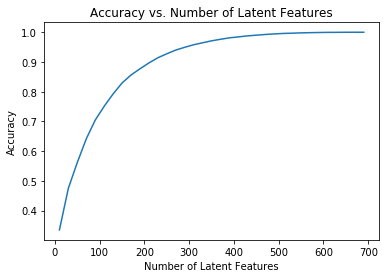

In [82]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [83]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)

    test_idx = user_item_test.index
    test_arts = [str(c) for c in user_item_test.columns]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [84]:
# in order to predict for users in the test set, they must be present in the training set
# determine how many users are in the test set that we have training data on
n = sum(user in list(user_item_train.index) for user in test_idx)
print(f'Number of users in test frame that are in train frame is {n}')

Number of users in test frame that are in train frame is 20


In [85]:
# number of users we can't make a prediction on
print(f'Number of users we cannot make a prediction on: {len(test_idx) - n}')

Number of users we cannot make a prediction on: 662


In [86]:
# similarly, in order to make prediction for an article in test, it must be present in the train frame
num_art = sum(art in df_train.article_id for art in df_test.article_id.unique())
print(f'Number of articles in test frame that are in train frame is {num_art}')

Number of articles in test frame that are in train frame is 574


In [87]:
print(f'Number of articles that we cannot make a prediction on: {len(test_arts) - num_art}')

Number of articles that we cannot make a prediction on: 0


In [88]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [89]:
# fit SVD on the user_item_train matrix
# make sure the columns and index are sorted ascending
u_train, s_train, vt_train = np.linalg.svd(user_item_train.sort_index(0).sort_index(1))

In [90]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [91]:
def factorized_matrix_recomposition(u, s, vt, compare_matrix, k=10):
    """ Compute the recomposed matrix from the u, s, and vt values of a decomposed matrix, 
    with k latent features.
    
    Args:
        u (matrix): Matrix representing row-latentfeature relationship
        s (arr): Vector representing latent features.
        vt (matrix): Matrix representing latentfeature-col relationship.
        compare_matrix (matrix): matrix to compare recomposed matrix to
        k (int): the number of latent features to keep when recomposing matrix.
            
    Returns:
        recomposed (matrix): recomposed matrix
        err (float): error as calculated by taking the sum of the absolute difference between
            the compare matrix and the recomposed matrix
   """
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    #print(u_new.shape, s_new.shape, vt_new.shape)
    
    # take dot product
    recomposed = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(compare_matrix, recomposed)
    
    # sum of absolute differences
    err = np.sum((np.abs(diffs.values)))
   
    return recomposed, err

In [92]:
# find the users that are present in both the test and train dataframes
train_in_test = user_item_train.index.isin(test_idx)
user_item_train[train_in_test]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3532,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
# we can index the u_train matrix in the same way
u_train[train_in_test].shape

(20, 4487)

In [94]:
# test it out with 10 latent features - recompose the user_item_train matrix
recomposed, err = factorized_matrix_recomposition(
    u_train[train_in_test], 
    s_train, 
    vt_train, 
    user_item_train[train_in_test].sort_index(), 
    k=500)

In [95]:
# what was our total error?
err

2.0

In [96]:
# check if the shape of our recomposition is correct
recomposed.shape == user_item_train[train_in_test].shape

True

In [97]:
# how accurate were we on recomposing our original matrix? Avg of T
(recomposed == user_item_train[train_in_test].values).mean()

0.999859943977591

In [98]:
# another way to check accuracy - total number of errors over total size of matrix
1 - (err / recomposed.size)

0.999859943977591

In [99]:
recomposed.sum()

254.0

In [100]:
user_item_train[train_in_test].values.sum()

256.0

Ok, now we've successfully recomposed the training matrix filtered to only users also present in the test 
matrix. However, we have not compared these values to the test matrix values, which we will do now.

In [101]:
# create a filter to only select test matrix where user_id is in train
test_in_train = user_item_test.index.isin(user_item_train.index)
user_item_test[test_in_train].head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
# create a filter to only select vt_train where user_item_train columns are in user_item_test columns
train_col_in_test = user_item_train.columns.isin(user_item_test.columns)

In [103]:
# try to recompose test one time with 10 latent features - have to filter
# the matrices appropriately to make sure the shapes are right
test_recomposed, test_err = factorized_matrix_recomposition(
    u_train[train_in_test], 
    s_train, 
    vt_train[:, train_col_in_test], 
    user_item_test[test_in_train],
    k=10)

In [104]:
print(f'For 10 latent features, sum of absolute error was {test_err}')

For 10 latent features, sum of absolute error was 248.0


In [105]:
print(f'For 10 latent features, our accuracy was {1 - test_err / test_recomposed.size}')

For 10 latent features, our accuracy was 0.978397212543554


In [106]:
(test_recomposed == user_item_test[test_in_train].values).mean()

0.978397212543554

Our accuracy with 10 latent features is not bad! However, consider how large and sparse of a matrix we are working with. 

In [107]:
# size of matrix
test_recomposed.size

11480

In [108]:
# number of actual articles recommended (where value == 1)
test_recomposed.sum()

50.0

In [109]:
# number of actual article interactions in filtered test data
user_item_test[test_in_train].values.sum()

218.0

So, we can see that while our accuracy is very good, it is easy to achieve a high accuracy because the matrix is so large and sparse. In our original test matrix, we have only 218 / 11480, or 1.9%, cells where the value == 1. 

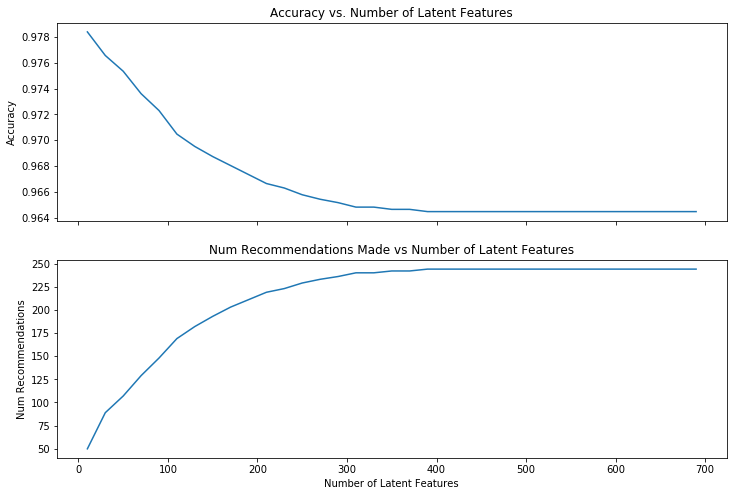

In [110]:
# plot accuracy vs number of latent features

sum_errs = []
num_recs = []
for k in num_latent_feats:
    recompose, err = factorized_matrix_recomposition(
        u_train[train_in_test], 
        s_train, 
        vt_train[:, train_col_in_test], 
        user_item_test[test_in_train].sort_index(), 
        k=k)
    sum_errs.append(err)
    num_recs.append(recompose.sum())
    
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(num_latent_feats, 1 - np.array(sum_errs) / recompose.size)
ax[1].plot(num_latent_feats, num_recs)

ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Num Recommendations')
ax[0].set_title('Accuracy vs. Number of Latent Features')
ax[1].set_title('Num Recommendations Made vs Number of Latent Features')
_ = plt.xlabel('Number of Latent Features')

The first plot above seems to indicate that we achieve our highest accuracy with matrix factorization and recomposition with a lower number of latent features. Intuitively this might not make sense. <br>
However, upon examining the second plot, you can see that the actual number of cells in the matrix with value=1 (recommending the article to the user) increase with the number of latent features. <br>
For our case, setting more cell values to 1 actually hurts the model in terms of accuracy. In fact, the <i> highest </i> accuracy could be achieved just by setting all cell values to 0!
<br>

In [111]:
# totally empty matrix of the correct shape
fake_recomposed = np.zeros(shape=recompose.shape)

In [112]:
(fake_recomposed == user_item_test[test_in_train].values).mean()

0.9810104529616724

As discussed, we can achieve 98% accuracy on test data by simply not recommending any articles at all! Seems rather silly. <br><br>
Another way to look at it would be to plot the proportion of correct recommendations and incorrect recommendations by number of latent features. To achieve this we could calculate precision and recall for each step. <br>
Precision can be intuitively understood as the number of True Positives / Number Positives Predicted. <br>
Recall can be intuitively understood as the number of True Positives Predicted / Number True Positives.

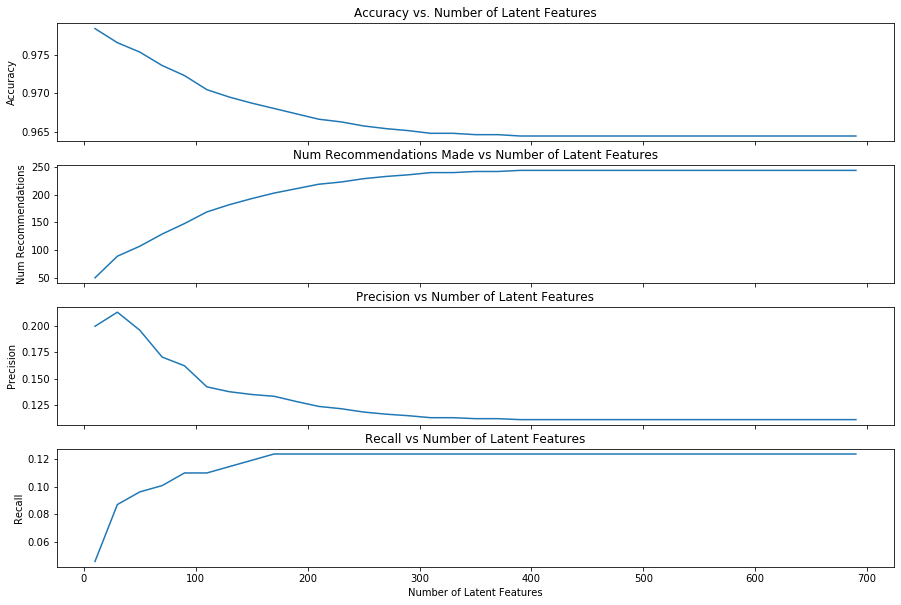

In [113]:
sum_errs = []
num_recs = []
precisions = []
recalls = []

for k in num_latent_feats:
    recompose, err = factorized_matrix_recomposition(
        u_train[train_in_test], 
        s_train, 
        vt_train[:, train_col_in_test], 
        user_item_test[test_in_train].sort_index(), 
        k=k)
    sum_errs.append(err)
    num_recs.append(recompose.sum())
    
    # precision
    # number of TPs predicted correctly
    tp = ((recompose == 1) & (user_item_test[test_in_train].values == 1)).sum()
    # number of positives predicted
    positives_predicted = recompose.sum()
    precision = tp / positives_predicted
    
    precisions.append(precision)
    
    # recall
    # total number of TPs
    all_tp = (user_item_test[test_in_train].values == 1).sum()
    recall = tp / all_tp

    recalls.append(recall)
    
# plot
fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
ax[0].plot(num_latent_feats, 1 - np.array(sum_errs) / recompose.size)
ax[1].plot(num_latent_feats, num_recs)
ax[2].plot(num_latent_feats, precisions)
ax[3].plot(num_latent_feats, recalls)

ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Num Recommendations')
ax[0].set_title('Accuracy vs. Number of Latent Features')
ax[1].set_title('Num Recommendations Made vs Number of Latent Features')
ax[2].set_title('Precision vs Number of Latent Features')
ax[2].set_ylabel('Precision')
ax[3].set_title('Recall vs Number of Latent Features')
ax[3].set_ylabel('Recall')
_ = plt.xlabel('Number of Latent Features')

The charts above reveal the truth of our model - even though accuracy is very high, > 95%, we do a very poor job of capturing the correct article recommendations. <br>
Precision peaks at slightly over 20% with 50 latent features. What this means is that at our best with 50 latent features, only 20% of our predicted positives are true positives. <br>
Recall peaks at around 12% with 170 latent features. What this means is that with 170 latent features we only capture 12% of all the true positives. <br>
Things don't look so rosy for our matrix factorization!

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

For a detailed discussion of previous questions concerning matrix factorization, see above. <br><br>
In this project we built several different types of recommendation systems and were able to successfully generate recommendations for users using these systems. <br>
The next step to improve recommendations would be to compare and contrast how the recommendation systems work on split train and test data. However, rather than splitting the behavior data in defined chunks, it would make more sense to randomly split into train and test groups to increase the probability of users appearing in both groups. <p>
After analyzing the results of the various recommendations systems using accuracy, recall, and precision, amongst other pertinent factors such as ease of deployment, etc., you might choose to combine several systems into one. 
For example the clustered-article Multi-Armed Bandit can help tackle the problem of cold users by recommending a diverse range of popular content, while also tackling the problem of cold articles by extracting text features from the article and clustering it with similar articles for recommendation. <br> However, you might choose to switch over to a collaborative type recommendation system or matrix factorization system once enough data has been accrued on new users/articles. For example, you might recommend content to users who have read >= 4 articles using a collaborative system, while employing the Bandit for users who have read less. <p>
Additionally, you might consider using other data points as ranking for articles instead of number of user interactions, such as publication date, trending popularity, etc. <p>
The last step would be to deploy your recommendation system(s) to users in stages in an A/B setup to determine if your system is causing article read rates to increase as you hoped.

In [114]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0